<a href="https://colab.research.google.com/github/nazaribih/ML_intro/blob/main/Diabetes_detection_Feature_Engineering_and_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*Diabetes Detection - Feature Engineering*

Nazarii Bihniak, Katarzyna Rogalska

## Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports and data loading

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# df read from Colab/github
# df = pd.read_csv("/content/diabetes_012_health_indicators_BRFSS2015.csv")

# df read from Google Drive if mounted - Nazarii
df = pd.read_csv("/content/drive/MyDrive/ml_diabetes/diabetes_012_health_indicators_BRFSS2015.csv")

# df read from Google Drive if mounted - Kasia
# df = pd.read_csv("/content/drive/MyDrive/CSV_ML/diabetes_012_health_indicators_BRFSS2015.csv")

## Train Validation Test Split

In [ ]:
from sklearn.model_selection import train_test_split

y = np.array(df['Diabetes_012'])
X = df.drop(['Diabetes_012'], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, stratify=Y_val, test_size=0.3, random_state=42)

#dane dla grupy walidacyjnej
test_df = X_test.copy()
test_df['Diabetes_012']=Y_test.copy()

#dane dla nas do walidowania modeli
val_df = X_val.copy()
val_df['Diabetes_012']= Y_val.copy()

#dane do trenowania
train_df = X_train.copy()
train_df['Diabetes_012']=Y_train.copy()


## Feature importance methods (original df)

**For categorical features we will use:**
* Chi-Squared Test - specifically for categorical variables!
* KBest
* Mutual Information
* RandomForest feature importance

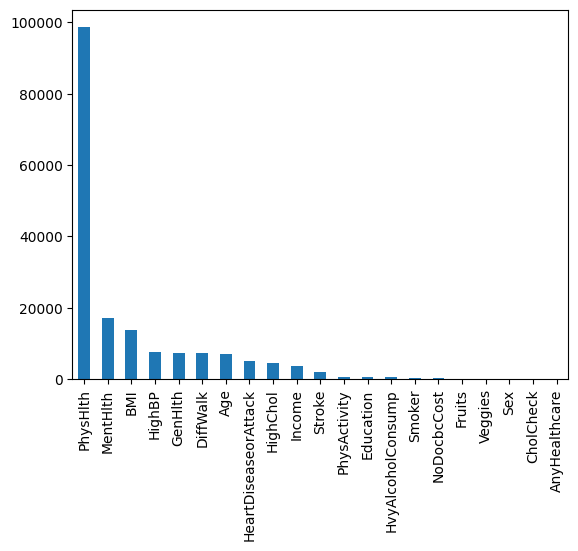

In [ ]:
# chi2
from sklearn.feature_selection import chi2

X= train_df.drop(columns=['Diabetes_012'])
y=train_df['Diabetes_012']

chi_scores = chi2(X,y)
chi_values = pd.Series(chi_scores[0], X.columns) # the higher the score,the  higher the importance
chi_values.sort_values(ascending=False, inplace=True)
chi_values.plot.bar()

chi_before_binning=chi_values

* We can see that the most important features are Physical and mental health, BMI, HighBP
* the least important features are AnyHealthCare, Cholcheck (which we will drop because we have results of chol check in HighChol column), sex, veggies, fruits
* we had similar observations from EDA

In [ ]:
# K best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
k_best = SelectKBest(score_func=f_classif, k=15)
k_best_fit = k_best.fit(X,y)
X.columns[k_best_fit.get_support(indices=True)].tolist()

['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Age',
 'Education',
 'Income']

* similar results as from chi2

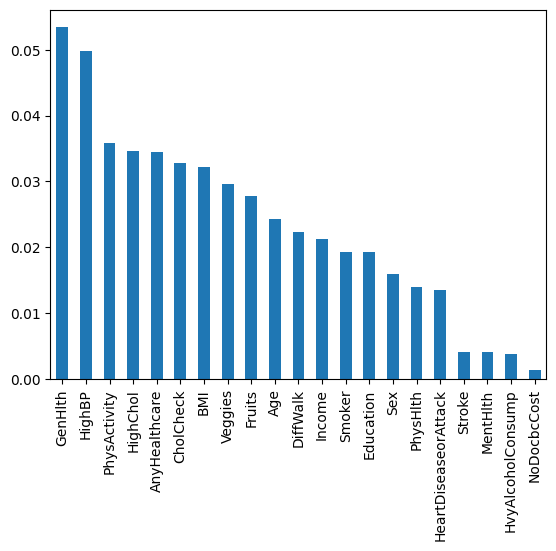

In [ ]:
# Mutual information
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X,y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False).plot.bar()

MI_before_binning=mutual_info

* results are slightly different from the previous ones
* AbyHealthcare,Fruits, Veggies,  which had no importance, is quite high here (what does it mean?)
* Many features that were 'important' in other metrics are also important using mutual information


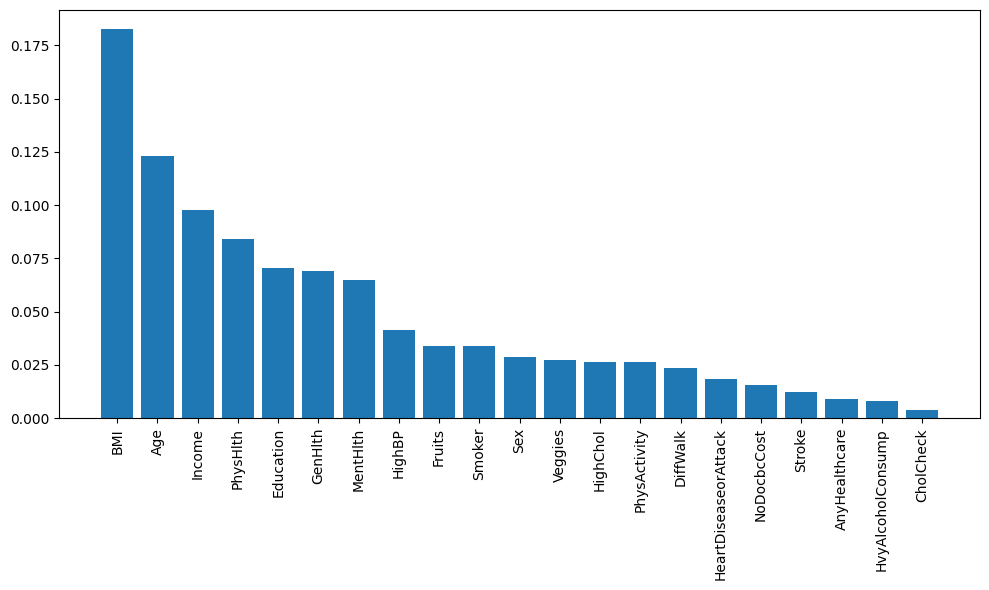

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

X=train_df.drop(columns='Diabetes_012')
y=train_df['Diabetes_012']
forest=RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X,y)
importances = forest.feature_importances_

feature_names = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

**Wnioski z powyższych**

- najważniejsze kolumny to: BMI, PhysHlth,MentHlth, HighBP, GenHlth, Age, Income, Education
- kolumny, które można próbować wyrzucić: AlcoholConsump, Cholcheck, NoDobcCost

## Feature binning

In [ ]:
def group_by_BMI(BMI):
    if BMI < 18.5:
        return 'Underweight'
    elif  BMI<25:
        return 'NormalWeight'
    elif BMI< 30:
        return 'Overweight'
    else:
        return 'Obesity'

def change_education_to_name(Education):
    if Education in [1,2]:
        return 'PrimaryEducation'
    elif Education in [3,4]:
        return 'HighSchoolEducation'
    else:
        return 'CollageEducation' #collage not finished and bachelors degrees

def group_income(Income):
    if Income<=3:
        return '<=15000$_income'
    elif Income<=5:
        return '15000$-25000$_income'
    elif Income<=7:
        return '25000$-50000$_income'
    else:
        return '50000$+_income'
def group_age(Age):
    if Age in[1,2,3]:
        return 'YoungAdult'
    elif Age in[4,5,6,7,8]:
        return 'Adult'
    else:
        return 'Elderly'

def group_mental_helath(MentalHealth): #????? JAk lepiej zrobić?
    if MentalHealth ==0:
      return 0
    else:
      return 1

def group_phys_health(PhysHealth):
    if PhysHealth in (0,1,2,3,4,5,6,8,9,10):
      return str(PhysHealth)
    elif PhysHealth in (11,12,13,14,15):
      return 'Medium_PhysHleth'
    else:
      return 'Bad_physHlth'


In [ ]:
def first_binning(X):
  A= X.copy()
  A['BMI']=A['BMI'].apply(group_by_BMI)
  A['Education'] = A['Education'].apply(change_education_to_name)
  A['Income']=A['Income'].apply(group_income)
  A['Age']=A['Age'].apply(group_age)
  return A

In [ ]:
from sklearn.preprocessing import LabelEncoder

def label_encoding(X):
  A= X.copy()
  label_encoder = LabelEncoder()
  A['BMI'] = label_encoder.fit_transform(A['BMI'])
  A['Age'] = label_encoder.fit_transform(A['Age'])
  A['Income'] = label_encoder.fit_transform(A['Income'])
  A['Education'] = label_encoder.fit_transform(A['Education'])
  A['MentHlth'] = label_encoder.fit_transform(A['MentHlth'])
  A['PhysHlth'] = label_encoder.fit_transform(A['PhysHlth'])
  return A

**Feature importance after first  binning**

In [ ]:
# chi2

X_train_binned1= first_binning(X_train) # wywołanie funkcji transofrmacji na X treningowym
X_train_labeled1 = label_encoding(X_train_binned1)

chi_scores = chi2(X_train_labeled1,Y_train)
chi_values = pd.Series(chi_scores[0], X_train_labeled1.columns) # the higher the score,the  higher the importance
chi_values.sort_values(ascending=False, inplace=True)

print("Chi scores before binning vs after binning:")
print("BMI:", chi_before_binning['BMI'] ,"VS" ,chi_values["BMI"])
print("Age:", chi_before_binning['Age'], "VS", chi_values["Age"])
print("Education:", chi_before_binning['Education'], "VS", chi_values['Education'])
print("Income:", chi_before_binning['Income']," Vs ", chi_values["Income"])


Chi scores before binning vs after binning:
BMI: 13860.484948725429 VS 185.73689075667676
Age: 7113.886132861852 VS 49.91950646150602
Education: 589.7624312460346 VS 1702.0804603979095
Income: 3759.8551882227644  Vs  0.23412971549633757


* The importance of BMI, Age, Income, MentalHealth, PhysHlth significantly decreased after binning
* the importance of education increased: 589 before, now: 1702

**The first binning wasn't succesfull, Maybe the original categories in our data shouldn't be changed to bigger bins**

Let's try binning BMI and Age the other way because they have the most unique values, and leave the other ones (they are already categorical)

In [ ]:
def second_binning(X):
  A=X.copy()
  A['BMI'] = pd.qcut(A['BMI'], q=10, labels=False)
  A['Age'] = pd.qcut(A['Age'], q=7 ,labels=[0,1,2,3,4,5,6])
  return A

In [ ]:
X_train_binned2 = second_binning(X_train)
X_train_labeled2 = label_encoding(X_train_binned2)

In [ ]:
# chi2 after binning BMI and Age
chi_scores = chi2(X_train_labeled2, Y_train)
chi_values = pd.Series(chi_scores[0], X_train_labeled2.columns) # the higher the score,the  higher the importance
chi_values.sort_values(ascending=False, inplace=True)

print("Chi scores before binning vs after binning:")
print("BMI:", chi_before_binning['BMI'] ,"VS" ,chi_values["BMI"])
print("Age:", chi_before_binning['Age'] ,"VS" ,chi_values["Age"])

Chi scores before binning vs after binning:
BMI: 13860.484948725429 VS 20241.676656833166
Age: 7113.886132861852 VS 7818.471902377956


* the importance of BMI and Age after new binning increased in chi2

## Adding new features

Let's add some new features to the data frame after 2 binning and see their importance

In [ ]:
train_df.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Diabetes_012'],
      dtype='object')

In [ ]:
def add_new_features_drop_some(X):
  A=X.copy()
  A['BloodHealth']= A['HighBP'] + A['HighChol']
  A['HeartHealth'] = A['Stroke'] + A['HeartDiseaseorAttack']
  A['Diat'] = A['Fruits'] + A['Veggies']
  A['BMI_GenHlth'] = A['BMI']* A['GenHlth']
  A['Mental_Phys_Health'] = A['MentHlth'] + A['PhysHlth']
  A= A.drop(columns =['CholCheck', "GenHlth","NoDocbcCost","HvyAlcoholConsump",'MentHlth', 'PhysHlth']) # drop reasons:  CholCheck - irrelevant we have HighChol as a result of cholCheck,
                                                                    #GenHlth - after creating a new column GenHlth correlation is very high with it
  return A

In [ ]:
X_train_new_features = add_new_features_drop_some(X_train_binned2)  # adding to binned 2 because we have to bin and the 2nd binning was more succesfull

<Axes: >

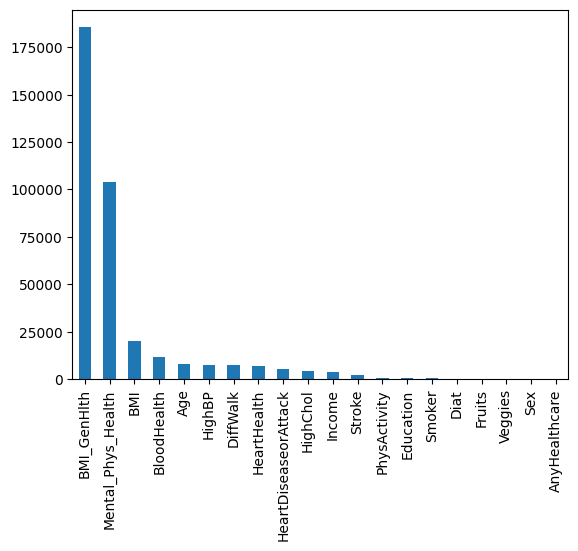

In [ ]:
#feature importance after adding new features

chi_scores = chi2(X_train_new_features,Y_train)
chi_values = pd.Series(chi_scores[0], X_train_new_features.columns) # the higher the score,the  higher the importance
chi_values.sort_values(ascending=False, inplace=True)

chi_values.plot.bar()

* We can see that BMi_GenHealth, bloodHealth and HeartHealth, Mental_phys_health have a significant importance, Diat and stimulants are not so dependent on the target

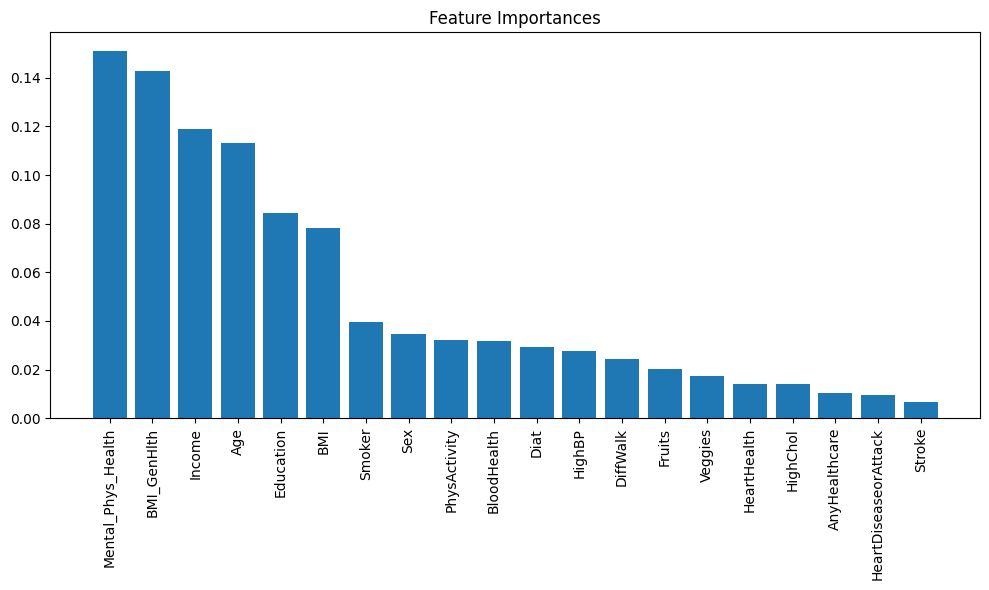

In [ ]:
#random forest feature importance
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=200, random_state=1)
forest.fit(X_train_new_features,Y_train)
importances = forest.feature_importances_

feature_names = X_train_new_features.columns
indices = importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_new_features.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_new_features.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

* the importance of Age and BMi remains the same
* We can see a quite high importance of new columns

Let's reduce dimensions and select only 10 best columns using SelectKBest

In [ ]:
X= X_train_new_features
y=Y_train

k_best = SelectKBest(score_func=f_classif, k=10)
k_best_fit = k_best.fit(X,y)
X.columns[k_best_fit.get_support(indices=True)].tolist()

['HighBP',
 'HighChol',
 'BMI',
 'HeartDiseaseorAttack',
 'DiffWalk',
 'Age',
 'Income',
 'BloodHealth',
 'HeartHealth',
 'BMI_GenHlth']

In [ ]:
X_train_10best = X_train_new_features[['HighBP',
 'HighChol',
 'BMI',
 'HeartDiseaseorAttack',
 'DiffWalk',
 'Age',
 'Income',
 'BloodHealth',
 'HeartHealth',
 'BMI_GenHlth']]

## DataFrames to test on

**At this point we have a few different data frames that we can use in our models (with their transormation functions)**

1) **train_df_binned_categorical** - Income,Education,BMI,Age binned and categorical encoding (first_tranfosmer)

2) **train_df_binned_labeled** - the same df as before but label encoding (second_transformer)

3) **train_df_binned2**  - only BMI and Age binned, label encoding (third_transformer)

4) **train_df_new_features** - train_df_binned2 with new columns and dropped irrelevant ones (fourth_transformer)

6) **train_df_10Best** - train_df_dropped with selectes 10 best columns

Also to add some one hot encoded dataframes


## Fist approach to modeling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

**Random Forest**

In [ ]:
# lets try to choose features that were the most important in Random Forest above

X= X_train_new_features[['Mental_Phys_Health','BMI_GenHlth', 'Income', 'Age', 'Education', 'BMI', 'Smoker','Sex', 'PhysActivity','BloodHealth']]
Y= Y_train
Xv = add_new_features_drop_some(X_val)[['Mental_Phys_Health','BMI_GenHlth', 'Income', 'Age', 'Education', 'BMI', 'Smoker','Sex', 'PhysActivity','BloodHealth']]

rf = RandomForestClassifier()
rf.fit(X,Y)
ytrain_predicted = rf.predict_proba(X)
yval_predicted = rf.predict_proba(Xv)


In [ ]:
auc = roc_auc_score(Y_train, ytrain_predicted, multi_class='ovr')
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val, yval_predicted, multi_class='ovr')
print("AUC for training set:", auc)

AUC for training set: 0.9913675388893305
AUC for training set: 0.6320861214013637


Very high score on traing set, much lower on validation suggests overfitting in some form

Let's tune parameters

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=10,stop=100,num=10)]
max_features =['auto', 'sqrt']
max_depth =[2,4]
min_samples_split =[2,5]
min_samples_leaf = [1,2]
bootstrap =[True,False]

parameters = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap
              }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_Randomgrid = RandomizedSearchCV(estimator = rf, param_distributions=parameters, cv=10)


In [ ]:
rf_Randomgrid.fit(X,Y)

In [ ]:
best_rfmodel = rf_Randomgrid.best_estimator_

In [ ]:
train_prediction = best_rfmodel.predict_proba(X)
val_predictions = best_rfmodel.predict_proba(Xv)


In [ ]:
auc = roc_auc_score(Y_train, train_prediction, multi_class='ovr')
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val, val_predictions, multi_class='ovr')
print("AUC for training set:", auc)

AUC for training set: 0.7684805643606448
AUC for training set: 0.7293345096641382


Better for validation set but also not too good (To experiment later)

**XGBoost**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb = GradientBoostingClassifier()
X= add_new_features_drop_some(X_train)
Y=Y_train
Xv = add_new_features_drop_some(X_val)
gb.fit(X,Y)
train_predictions = gb.predict_proba(X)
val_predictions = gb.predict_proba(Xv)

In [ ]:
auc = roc_auc_score(Y_train, train_predictions, multi_class='ovr')
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val, val_predictions, multi_class='ovr')
print("AUC for training set:", auc)

AUC for training set: 0.7937032937339034
AUC for training set: 0.783714600510704


A little better

## Further modeling - yes or no diabetes

Let's remove all the "prediabetes" cases for prediction if the person has diabetes or no



### Data modification and featuring

In [ ]:
df_1 = df[df['Diabetes_012'] != 1]

In [ ]:
from sklearn.model_selection import train_test_split

yy = np.array(df['Diabetes_012'])
XX = df.drop(['Diabetes_012'], axis=1)

X_train1, X_val1, Y_train1, Y_val1 = train_test_split(XX, yy, stratify=yy, test_size=0.3, random_state=42)

X_val1, X_test1, Y_val1, Y_test1 = train_test_split(X_val1, Y_val1, stratify=Y_val1, test_size=0.3, random_state=42)

#dane dla grupy walidacyjnej
test_df1 = X_test1.copy()
test_df1['Diabetes_012']=Y_test1.copy()

#dane dla nas do walidowania modeli
val_df1 = X_val1.copy()
val_df1['Diabetes_012']= Y_val1.copy()

#dane do trenowania
train_df1 = X_train1.copy()
train_df1['Diabetes_012']=Y_train1.copy()


In [ ]:
X_train1 = add_new_features_drop_some(X_train1)

In [ ]:
X_train1 = first_binning(X_train1)

In [ ]:
X_val1 = add_new_features_drop_some(X_val1)

In [ ]:
X_val1 = first_binning(X_val1)

In [ ]:
X_train1 = X_train1[['Mental_Phys_Health','BMI_GenHlth', 'Income', 'Age', 'Education', 'BMI', 'Smoker','Sex', 'PhysActivity','BloodHealth']]
X_val1 = X_val1[['Mental_Phys_Health','BMI_GenHlth', 'Income', 'Age', 'Education', 'BMI', 'Smoker','Sex', 'PhysActivity','BloodHealth']]

In [ ]:
from sklearn.preprocessing import LabelEncoder

def label_encoding_half(X):
  A= X.copy()
  label_encoder = LabelEncoder()
  A['BMI'] = label_encoder.fit_transform(A['BMI'])
  A['Age'] = label_encoder.fit_transform(A['Age'])
  A['Income'] = label_encoder.fit_transform(A['Income'])
  A['Education'] = label_encoder.fit_transform(A['Education'])
  return A

In [ ]:
X_train1 = label_encoding_half(X_train1)

In [ ]:
X_val1 = label_encoding_half(X_val1)

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train1, Y_train1)

RandomForestClassifier()

In [ ]:
ytrain_predict = rf.predict_proba(X_train1)
yval_predict = rf.predict_proba(X_val1)

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_train, ytrain_predict, multi_class='ovr')
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val, yval_predict, multi_class='ovr')
print("AUC for training set:", auc)

AUC for training set: 0.9786286091298608
AUC for training set: 0.6936702173506403


In [ ]:
n_estimators = [int(x) for x in np.linspace(start=10,stop=100,num=10)]
max_features =['auto', 'sqrt']
max_depth =[2,4]
min_samples_split =[2,5]
min_samples_leaf = [1,2]
bootstrap =[True,False]

parameters = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap
              }


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_Randomgrid = RandomizedSearchCV(estimator = rf, param_distributions=parameters, cv=10)


In [ ]:
rf_Randomgrid.fit(X_train1,Y_train1)

In [ ]:
best_rfmodel = rf_Randomgrid.best_estimator_

In [ ]:
train_predictions = best_rfmodel.predict_proba(X_train1)
val_predictions = best_rfmodel.predict_proba(X_val1)

In [ ]:
auc = roc_auc_score(Y_train1, train_predictions, multi_class='ovr')
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val1, val_predictions, multi_class='ovr')
print("AUC for validation set:", auc)

AUC for training set: 0.7668479849393918
AUC for validation set: 0.7682643216153382


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

model.fit(X_train1, Y_train1)

y_pred_proba_train = model.predict_proba(X_train1)
y_pred_proba_val = model.predict_proba(X_val1)

In [ ]:
auc = roc_auc_score(Y_train, y_pred_proba_train, multi_class='ovr')
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val, y_pred_proba_val, multi_class='ovr')
print("AUC for validation set:", auc)

AUC for training set: 0.7564328907826479
AUC for training set: 0.755883511185273


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

model.fit(X_train1, Y_train1)

y_pred_proba_train = model.predict_proba(X_train1)
y_pred_proba_val = model.predict_proba(X_val1)

In [ ]:
auc = roc_auc_score(Y_train, y_pred_proba_train, multi_class='ovr')
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val, y_pred_proba_val, multi_class='ovr')
print("AUC for training set:", auc)

AUC for training set: 0.8842178259219521
AUC for training set: 0.647490793554475


### LGBM

In [ ]:
import lightgbm as lgb

model = lgb.LGBMClassifier()

model.fit(X_train, Y_train)

y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_val = model.predict_proba(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 177576, number of used features: 21
[LightGBM] [Info] Start training from score -0.171487
[LightGBM] [Info] Start training from score -4.003208
[LightGBM] [Info] Start training from score -1.970896


In [ ]:
auc = roc_auc_score(Y_train, y_pred_proba_train, multi_class='ovr')
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val, y_pred_proba_val, multi_class='ovr')
print("AUC for training set:", auc)

AUC for training set: 0.8286842981071377
AUC for training set: 0.7844024578683723
